In [230]:
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from hmmlearn.hmm import CategoricalHMM
import RNA
import logomaker
import matplotlib.pyplot as plt

In [4]:
%cd /Users/hcgill/projects/Bioinformatics/binfo1-datapack1/pileup

/Users/hcgill/projects/Bioinformatics/binfo1-datapack1/pileup


In [2]:
!for i in $(seq 1 19); do; samtools view -b -o CLIP-chr${i}.bam CLIP-35L33G.bam chr${i}; done

In [3]:
!for i in $(seq 1 19); do; samtools mpileup CLIP-chr${i}.bam > CLIP-chr${i}.pileup; done

[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files


In [14]:
bases = ['A','T','G','C']
def Shanon_entropy(seq):
    cnts = [seq.count('A'), seq.count('T'), seq.count('G'), seq.count('C')]
    N_tot = sum(cnts)
    if N_tot == 0:
        return 0
    else:
        freqs = [cnt/N_tot for cnt in cnts]
        Shanon = [-freq*np.log2(freq) for freq in freqs if freq > 0]
        return sum(Shanon)

In [5]:

pileup = pd.read_csv('CLIP-chr1.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])

In [10]:
toremove = re.compile('[<>$*#^!]')
pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))
pileup['N_tot'] = pileup['matches'].apply(lambda x: len(x))

In [11]:
pileup.head()

,chrom,pos,_ref,count,basereads,quals,matches,N_tot
0,chr1,3056473,N,4,^!G^!G^!G^!G,HGGI,GGGG,4
1,chr1,3056474,N,4,AAAA,HB@I,AAAA,4
2,chr1,3056475,N,4,AAAA,GG?I,AAAA,4
3,chr1,3056476,N,4,TTTT,HGGH,TTTT,4
4,chr1,3056477,N,4,GGGG,HEGI,GGGG,4


In [12]:
pileup_N50 = pileup[pileup['N_tot'] >= 50].copy()
len(pileup_N50)

241072

In [18]:
Shanon_list = []
for match in pileup_N50['matches']:
    Shanon_list.append(Shanon_entropy(match))
pileup_N50['Shanon'] = Shanon_list

In [21]:
pileup_N50[pileup_N50['Shanon'] > 1.2].to_csv('CLIP-chr1.shanon.tsv',sep='\t',header=True,index=False)

In [22]:
for i in range(19):
    file_name = 'CLIP-chr' + str(i+1)
    pileup = pd.read_csv(file_name + '.pileup', sep='\t', names=['chrom', 'pos', '_ref', 'count', 'basereads', 'quals'])
    toremove = re.compile('[<>$*#^!]')
    pileup['matches'] = pileup['basereads'].apply(lambda x: toremove.sub('', x))
    pileup['N_tot'] = pileup['matches'].apply(lambda x: len(x))
    pileup_N50 = pileup[pileup['N_tot'] >= 50].copy()
    Shanon_list = []
    for match in pileup_N50['matches']:
        Shanon_list.append(Shanon_entropy(match))
    pileup_N50['Shanon'] = Shanon_list
    pileup_N50[pileup_N50['Shanon'] > 1.2].to_csv(file_name+'.tsv',sep='\t',header=True,index=False)
    del pileup
    del pileup_N50

In [266]:
windows = []
raw_seqs = []
for i in range(19):
    fasta = "/Users/hcgill/projects/Bioinformatics/Reference/chr"+str(i+1)+".fa"
    pileup = pd.read_csv("/Users/hcgill/projects/Bioinformatics/binfo1-datapack1/pileup/CLIP-chr"+str(i+1)+".tsv",sep="\t")
    with open(fasta) as handle:
        for record in SeqIO.parse(handle,'fasta'):
            seq = str(record.seq.upper())
            for pos in pileup['pos']:
                window = seq[int(pos)-9:int(pos)+9]
                if 'N' not in window:
                    rna, score = RNA.fold(window)
                    hmm_seq = "S"
                    for j in range(len(window)):
                        if rna[j] == ".":
                            hmm_seq += window[j]
                        else:
                            hmm_seq += rna[j]
                    windows.append(hmm_seq)
                    raw_seqs.append(window)

In [103]:
f = open("hmm_seq.txt", 'w')
for window in windows:
    print(window, file=f, end="\n")
f.close()

In [198]:
transition = np.loadtxt('transition.csv',delimiter=',',dtype='float32')
transition = transition/transition.sum(axis=1)[:,np.newaxis]
start = np.loadtxt('start.csv',delimiter=',').tolist()
emission = np.transpose(np.loadtxt('emission.csv',delimiter=','))

In [199]:
def encode_seq(seq):
    decoding_sym = {'S':0, 'A':1, 'C':2,'G':3,'T':4,'(':5,')':6}
    seq_array = np.array([decoding_sym[x] for x in seq])
    return seq_array

In [200]:
train_seq = np.array([], dtype=int)
train_len = np.array([], dtype=int)
for window in windows:
    train_seq = np.concatenate((train_seq, encode_seq(window)))
    train_len = np.append(train_len, len(window))

In [201]:
train_seq

array([0, 1, 4, ..., 6, 6, 6])

In [213]:
HMM = CategoricalHMM(n_components = 19, init_params='', params='et',n_features=7,n_iter=1000)
HMM.transmat_ = transition
HMM.emissionprob_ = emission
HMM.startprob_ = start

In [214]:
HMM.fit(train_seq.reshape(-1,1),train_len)

CategoricalHMM(init_params='', n_components=19, n_features=7, n_iter=1000,
               params='et', random_state=RandomState(MT19937) at 0x1080FEA40)

In [215]:
HMM.emissionprob_

array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000],
       [0.00000000e+000, 2.81206467e-001, 1.48384825e-001,
        1.84821056e-001, 2.50889642e-001, 1.34698010e-001,
        0.00000000e+000],
       [0.00000000e+000, 1.59324484e-001, 6.86052080e-002,
        9.25207540e-002, 1.05320465e-001, 5.74229089e-001,
        0.00000000e+000],
       [0.00000000e+000, 6.39347638e-002, 2.67838100e-002,
        4.01308880e-002, 3.80754258e-002, 8.31075112e-001,
        0.00000000e+000],
       [0.00000000e+000, 2.32953679e-002, 4.40639229e-003,
        1.85515083e-002, 1.56588565e-002, 9.38087875e-001,
        0.00000000e+000],
       [0.00000000e+000, 2.64687219e-002, 4.87416810e-003,
        2.80822152e-002, 1.84118198e-002, 9.22163075e-001,
        0.00000000e+000],
       [0.00000000e+000, 1.09371331e-001, 2.87955300e-002,
        9.53757352e-002, 6.89709728e-002, 6.97486431e-001,
        0.00000000

In [216]:
df_emission = pd.DataFrame(HMM.emissionprob_)


In [265]:
df_emission.columns = ['S','A','C','G','U','5','3']
df_emission.to_csv('HMM_emission.tsv',sep='\t',index=False,header=None)
df_emission_sub = df_emission[['A','C','G','U','5','3']]

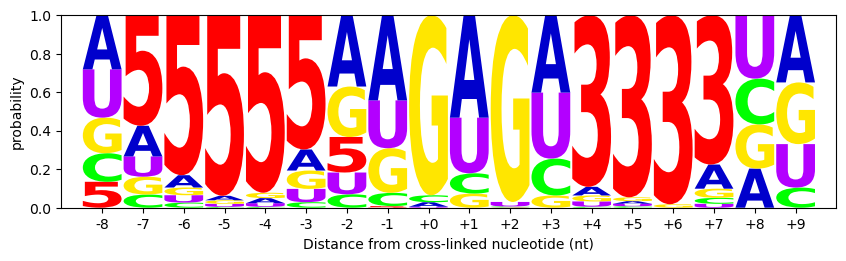

In [263]:
color_scheme = {
    'A' : [0,0,.8],
    'C' : [0,1,0],
    'G' : [1,.9,0],
    'U' : [.7,0,1],
    '5' : [1,.0,.0],
    '3' : [1,.0,.0]
}
ss_logo = logomaker.Logo(df_emission_sub, color_scheme=color_scheme)
ss_logo.ax.set_xlim(0,19)
ss_logo.ax.set_xticks(range(1,len(df_emission_sub)))
ss_logo.ax.set_xticklabels('%+d'%x for x in range(-8,10))
ss_logo.ax.set_ylabel('probability')
ss_logo.ax.set_xlabel('Distance from cross-linked nucleotide (nt)')
#plt.show()
plt.savefig('Logo.jpg')

In [232]:
df_emission_sub

,A,C,G,U,5,3
0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00
1,2.812065e-01,1.483848e-01,0.184821,2.508896e-01,0.134698,0.000000e+00
2,1.593245e-01,6.860521e-02,0.092521,1.053205e-01,0.574229,0.000000e+00
3,6.393476e-02,2.678381e-02,0.040131,3.807543e-02,0.831075,0.000000e+00
4,2.329537e-02,4.406392e-03,0.018552,1.565886e-02,0.938088,0.000000e+00
5,2.646872e-02,4.874168e-03,0.028082,1.841182e-02,0.922163,0.000000e+00
6,1.093713e-01,2.879553e-02,0.095376,6.897097e-02,0.697486,0.000000e+00
7,3.704430e-01,6.955382e-02,0.262155,1.133017e-01,0.184546,0.000000e+00
8,4.424273e-01,6.877280e-02,0.231807,2.484571e-01,0.008536,0.000000e+00
9,2.309767e-02,3.637002e-02,0.935230,5.302756e-03,0.000000,0.000000e+00
